# Delivery Order Analysis Task
We provide a small data sample about a series of order deliveries extracted from a specific day.

The homework requires to investigate it, by first answering a series of pre-defined questions, and then, by freely propose additional searches and analysis that will help understanding the data and extract other important insights.

The resulting analysis should be presented with a Jupyter notebook, preferably with Python.

## Analysis
* Number of drivers available in average per hour and for each order invitation. Any area in which we need to increase the coverage? maybe in a certain time range?
* Statistics and quality of the automatic assignments. How is it working? Can you estimate its performance?
* Quality of the estimation time the driver will take to arrive at the pick-up and drop-off (called estimated_arrival in the JSON). This is a value that is estimated by our Dispatcher algorithm. How is it doing our estimator?
* Drivers Performance: avg. time to accept a job, avg. rejection (i.e., order that goes in timeout because not accepted), avg. time for delivery, any other?
Note that these are kind of Business Questions: there can be cases in which there is not an easy/possible answer, but also cases that lead to deeper investigations and new questions.

---

In [1]:
# imports

%matplotlib inline

import json
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from datetime import datetime, timedelta


pp = pprint.PrettyPrinter(indent=4)

In [2]:
# read data
data = []
with open('./orders-2018-01-27.log') as f:
    for line in f:
        data.append(json.loads(line.encode('utf-8')))
        
# pp.pprint(data[0])

## Data exploration

In [3]:
# order id
print("id:" + "\t\t\t" + data[4]["_id"]["$oid"])

# driver id
print("driver id: " + "\t\t" + data[4]["dispatch_current_rank"]["driver_id"])

# created
print("created at: " + "\t\t" + data[4]["created_at"]["$date"])

# estimated
print("estimated: " + "\t\t" + data[4]["estimated_time"]["$date"])

# pick up done
print("pick up done at: " + "\t" + data[4]["pickup_done_at"]["$date"])

# delivery
print("delivered at: " + "\t\t" + data[4]["delivery_done_at"]["$date"])

id:			5a6c6552fe78590001016128
driver id: 		59dd48a9d502cf00014e2139
created at: 		2018-01-27T11:41:06.650+0000
estimated: 		2018-01-27T12:25:00.000+0000
pick up done at: 	2018-01-27T12:09:50.678+0000
delivered at: 		2018-01-27T12:19:16.602+0000


In [4]:
# convert to pandas dataframe
df = pd.DataFrame(data)

In [5]:
# data wrangling

for index, row in df.iterrows():
    
    # creating dates
    
    dt_created_at = datetime.strptime(row['created_at']['$date'][:-5],'%Y-%m-%dT%H:%M:%S.%f')
    df.loc[index,'dt_created_at'] = dt_created_at
    
    # we can use the hour resolution to link each order to an hour interval
    df.loc[index,'dt_created_at_min'] = dt_created_at.replace(minute=0, second=0, microsecond=0)
    
    if row['pickup_done_at'] > 0:
        dt_pickup_done_at = datetime.strptime(row['pickup_done_at']['$date'][:-5],'%Y-%m-%dT%H:%M:%S.%f')
        df.loc[index,'dt_pickup_done_at'] = dt_pickup_done_at  
    
    if row['delivery_done_at'] > 0:
        dt_delivery_done_at = datetime.strptime(row['delivery_done_at']['$date'][:-5],'%Y-%m-%dT%H:%M:%S.%f')
        df.loc[index,'dt_delivery_done_at'] = dt_delivery_done_at
        
    dt_estimated_time = datetime.strptime(row['estimated_time']['$date'][:-5],'%Y-%m-%dT%H:%M:%S.%f')
    df.loc[index, 'dt_estimated_time'] = dt_estimated_time

    total_time = (dt_delivery_done_at-dt_created_at).total_seconds()/60
    df.loc[index, 'total_time'] = total_time

    delay_time = (dt_delivery_done_at-dt_estimated_time).total_seconds()/60
    df.loc[index, 'delay_time'] = delay_time
    
    if delay_time > 0:
        df.loc[index, 'delayed'] = 1
    else:
        df.loc[index, 'delayed'] = 0        
        
    # creating order id
    
    if row['_id']:
        try:
            _id = row['_id']['$oid']
        except:
            _id = row['_id']
        df.loc[index, '_id'] = _id
        
        
    # creating service area id
    
    if row['service_area_id']:
        try:
            area_id = row['service_area_id']['$oid']
        except:
            area_id = row['service_area_id']
        df.loc[index, 'area_id'] = area_id
        
    # creating waypoint id
    
    if row['way_point_id']:
        try:
            waypoint_id = row['way_point_id']['$oid']
        except:
            waypoint_id = row['way_point_id']
        df.loc[index, 'waypoint_id'] = waypoint_id
        
        
    # creating the driver id
    
    if row["dispatch_current_rank"]["driver_id"]:
        try:
            driver_id = row["dispatch_current_rank"]["driver_id"]["$oid"]
        except:
            driver_id = row["dispatch_current_rank"]["driver_id"]
        df.loc[index, 'driver_id'] = driver_id
    
df.tail(3)

,_id,_keywords,auto_assignment_count,cash_on_delivery,company_id,created_at,delivery_done_at,dispatch_current_rank,dispatch_driver_ranking,dispatch_status,...,dt_created_at_min,dt_pickup_done_at,dt_delivery_done_at,dt_estimated_time,total_time,delay_time,delayed,area_id,waypoint_id,driver_id
349,5a6cf6ce38eb7f00019e11ec,"[3nb, 4060589, 4np, 5ea4d0b0663549ccb7af343d76...",0,False,{u'$oid': u'5a42bc1f755ec20001abf5d8'},{u'$date': u'2018-01-27T22:01:50.316+0000'},{u'$date': u'2018-01-27T22:23:59.120+0000'},{u'base_version': u'e251825f92def40f28d083c058...,[{u'base_version': u'e251825f92def40f28d083c05...,accepted,...,2018-01-27 22:00:00,2018-01-27 22:19:12.134,2018-01-27 22:23:59.120,2018-01-27 22:40:00,22.146733,-16.014667,0.0,59ef610c7e94fe000185da42,59dd20d22483e200018daae9,59dd1f4e0738f50001df0408
350,5a6cf7900c0888000154b21a,"[1ss, 501010770, 6ah, com, ha0, ha9, javed, kf...",0,False,{u'$oid': u'5a42bc1f755ec20001abf5d8'},{u'$date': u'2018-01-27T22:05:04.044+0000'},{u'$date': u'2018-01-27T22:25:34.369+0000'},{u'base_version': u'07901831812a3d244a428dbfe1...,[{u'base_version': u'a4be56a337e98627a56b129b7...,accepted,...,2018-01-27 22:00:00,2018-01-27 22:17:46.150,2018-01-27 22:25:34.369,2018-01-27 22:40:00,20.505417,-14.427183,0.0,59ef610c7e94fe000185da42,5a4f4b1911e4e60001a98665,59dd4ce0d502cf00014e213e
351,5a6cf87d45fc9000016f172b,"[2ln, 501013121, 6ah, com, domingues, gmail, h...",0,False,{u'$oid': u'5a42bc1f755ec20001abf5d8'},{u'$date': u'2018-01-27T22:09:01.770+0000'},{u'$date': u'2018-01-27T22:35:29.160+0000'},{u'base_version': u'5d62396e50e07133edacfa14c4...,[],accepted,...,2018-01-27 22:00:00,2018-01-27 22:25:22.126,2018-01-27 22:35:29.160,2018-01-27 22:45:00,26.456500,-9.514000,0.0,59ef610c7e94fe000185da42,5a4f4b1911e4e60001a98665,5a4d24e4b557450001e6f341


In [6]:
# time history of data

print(df['dt_created_at'].min())
print(df['dt_created_at'].max())

print(df['dt_delivery_done_at'].min())
print(df['dt_delivery_done_at'].max())


2018-01-25 18:53:43.873000
2018-01-27 22:09:01.770000
2018-01-25 20:30:02.533000
2018-01-27 22:40:55.784000


In [7]:
# there are only 4 different areas
print('\nNumber of areas: ' + '\t' + str(len(df['area_id'].unique())))

# there are 40 different drivers
print('Number of drivers: ' + '\t' + str(len(df['driver_id'].unique())))

# there are 352 observations (= )
print('Number of orders: ' + '\t' + str(len(df['_id'].unique())))

print('\nNumber of Drivers per Area')
print(df.groupby('area_id')['driver_id'].nunique().reset_index())


Number of areas: 	4
Number of drivers: 	40
Number of orders: 	352

Number of Drivers per Area
                    area_id  driver_id
0  59d74a180d73470001565cd1          6
1  59ef610c7e94fe000185da42         24
2  59ef61bf7e94fe000185da43          6
3  59ef6b21366e6500018bc9b9          4


In [8]:
area_list = list(df['area_id'].unique())

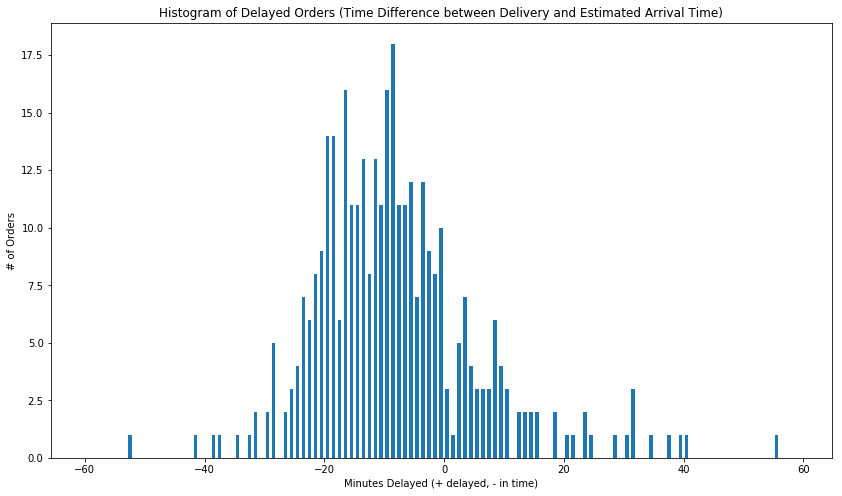

In [9]:
# df.sort_values(by=['dif_min_delivery_estimated'], ascending=False)
plt.figure(num=None, figsize=(14, 8))
plt.hist(df['delay_time'], bins=range(-60, 60, 1), rwidth=0.6)
plt.title('Histogram of Delayed Orders (Time Difference between Delivery and Estimated Arrival Time)')
plt.xlabel('Minutes Delayed (+ delayed, - in time)')
plt.ylabel('# of Orders')
plt.show()

We can observe that the majority of the orders are delivered before the estimated arrival time. There are some orders delivered after the estimated arrival time. It seems reasonable to consider that "as delayed" orders delivered 5 minutes later than originally scheduled.

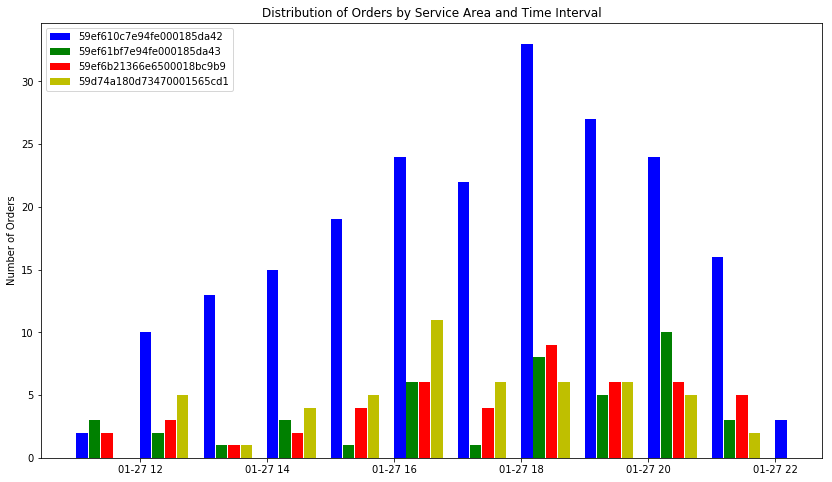

In [10]:
# all possible combinations of date of order creation and area id
idx = pd.MultiIndex.from_product((df['dt_created_at_min'].unique(), df['area_id'].unique()))

# ppd = df.groupby(['dt_created_at_min','area_id']).count().reindex(idx)

df2 = df.groupby([df['dt_created_at_min'], df['area_id']], as_index=False)['_id'].count()

df1 = pd.DataFrame(idx, columns=['temp'])
for index, row in df1.iterrows():
    df1.loc[index,'dt_created_at_min'] = row[0][0]
    df1.loc[index,'area_id'] = row[0][1]

df1 = df1.drop('temp', axis=1)
df_created_area = pd.merge(df1, df2, how='left', on=['dt_created_at_min','area_id'])


# focus on >= 20180127

df_created_area = df_created_area[df_created_area['dt_created_at_min'] > datetime(2018,1,27,10)]

plt.figure(num=None, figsize=(14, 8))

color_list = ['b', 'g', 'r', 'y']

x = df_created_area['dt_created_at_min'].unique()

v = df_created_area[df_created_area['area_id']==area_list[0]]['_id']
u = df_created_area[df_created_area['area_id']==area_list[1]]['_id']
y = df_created_area[df_created_area['area_id']==area_list[2]]['_id']
z = df_created_area[df_created_area['area_id']==area_list[3]]['_id']

w = 700000000000 # time offset for plotting bars of different areas (not really elegant ...)

ax = plt.subplot(111)
ax.bar(x,     v, width=0.0075, color=color_list[0], align='edge')
ax.bar(x+w,   u, width=0.0075, color=color_list[1], align='edge')
ax.bar(x+2*w, y, width=0.0075, color=color_list[2], align='edge')
ax.bar(x+3*w, z, width=0.0075, color=color_list[3], align='edge')

ax.legend((area_list[0],area_list[1],area_list[2],area_list[3]), loc='upper left')
ax.xaxis_date()


plt.ylabel("Number of Orders")
plt.title('Distribution of Orders by Service Area and Time Interval')

plt.show()

It can be clearly seen that the blue service area has the majority of the orders (most of the time, at each hour, the volume of deliveries made in the blue area is larger than the total volume of deliveries in the rest of the other areas).

In [ ]:
df.groupby(['area_id', 'waypoint_id']).size().reset_index().rename(columns={0:'count'})

,area_id,waypoint_id,count
0,59d74a180d73470001565cd1,59ce160ce21ccb00018947f1,51
1,59ef610c7e94fe000185da42,59dd1dd45771ad000198c611,19
2,59ef610c7e94fe000185da42,59dd1fe40738f50001df040a,32
3,59ef610c7e94fe000185da42,59dd206cae6ef50001ea5bd8,56
4,59ef610c7e94fe000185da42,59dd20d22483e200018daae9,66
5,59ef610c7e94fe000185da42,5a4f4b1911e4e60001a98665,37
6,59ef61bf7e94fe000185da43,59dd2014c13c58000103077d,43
7,59ef6b21366e6500018bc9b9,59dd1f202483e200018daadd,48


We can see that there are multiple waypoints in blue area to channel the high demand of orders

In [ ]:
# Temporal distribution of orders by Area and Hour Interval

f, axarr = plt.subplots(2, 2, figsize=(15,15))

k = 0
for i in range(0,2):
    for j in range(0,2):
        df2 = df[df['area_id']==area_list[k]][['driver_id', 'dt_created_at', 'dt_delivery_done_at']]
        df2 = df2.dropna()
        df2.amin = pd.to_datetime(df2['dt_created_at']).astype(datetime)
        df2.amax = pd.to_datetime(df2['dt_delivery_done_at']).astype(datetime)
        axarr[i, j].hlines(df2.index, date2num(df2.amin), date2num(df2.amax), color=color_list[k])
        axarr[i, j].set_xlim(datetime(2018,1,27,11,0,0),datetime(2018,1,27,23,0,0))
        axarr[i, j].set_title(area_list[k])
        axarr[i, j].set_ylabel('Drivers')
        k += 1

plt.show()  

There are no further conclusions that can be extracted from charts: 
* blue area has way more orders
* perhaps the yellow area (`59d74a180d73470001565cd1`) seems to experiment longer delivery times (from order creation to delivery)

In [ ]:
print('')
print('Mean of Total Time per Area')
print('*'*100)
print(df.groupby('area_id')['total_time'].mean())
print('')

# compute the mean of the delay time per area (leave out non-delayed orders)
print('Mean of Delay Time per Area')
print('*'*100)
print(df[df['delayed']==1].groupby('area_id')['delay_time'].mean())


* Yes, there is correlation between longer delivery times and delays.
* The order of magnitude of these timings seems reasonable.

---

## Number of drivers available per hour interval and service area

Number of drivers available in average per hour and for each order invitation. Any area in which we need to increase the coverage? maybe in a certain time range?

__Data Interpretation__

* The dispatch system generates a ranking of drivers that are suitable to pick up and drop off deliveries. The ranking, if generated, is shown as a list of drivers (`dispatch_driver_ranking`). Further, the driver that is actually assigned to the order is the driver included in the `dispatch_current_rank`. The dispatcher also creates a list of jobs for each driver with the estimated arrival and leave deadlines (e.g., pick-up and delivery jobs). All this data is estimated by the dispatcher algorithm.

* Additionally, each order contains the estimated delivery deadline given by Just Eat (`estimated_time`).

* Finally, the actual times when the order delivery is picked up and delivered by the actual driver are also included in the order data (`pickup_done_at`, `delivery_done_at`, ...).

__Assumptions__

* The number of drivers available for a given order are all the drivers considered and ranked by the dispatch algorithm plus the actual driver that eventually carries out the delivery.
* We will reference all order calculations to its creation time (in this way we can contrast different information at the same point in time).
* Delays are calculated using the estimated delivery deadline given by Just Eat (`estimated_time - deliver_done_at`).

__Caveats__

* There might be cases where a delivery was created in an hour interval but the delay occurred in the following hour interval. In those cases we are still anchoring that delay to the creation time of the order.

__Approach__

Based on these assumptions I can approximate how many drivers are available (= number of drivers ranked by the dispatcher + actual driver) for each hour interval and service area.

In [ ]:
# the number of drivers available for each order invitation is equal to the sum of all 
# the drivers included in the ranking and the current driver

for index, row in df.iterrows():
    n_drivers = 1 # current driver
    if row['dispatch_driver_ranking']: # the current driver does not overlap with drivers in ranking 
        try:
            n_drivers += len(row['dispatch_driver_ranking'])
        except:
            pass
    df.loc[index, 'n_drivers'] = n_drivers

In [ ]:
df_average = df.groupby('dt_created_at_min')['n_drivers'].mean().reset_index()

plt.figure(num=None, figsize=(8, 8))

x = df_average['dt_created_at_min'].unique()
y = df_average['n_drivers']

ax = plt.subplot(111)
ax.bar(x, y, width=0.03, align='edge')
ax.yaxis.grid(which='major', linewidth=0.5)
ax.set_xlim(datetime(2018,1,27,10,0,0), datetime(2018,1,28,0,0,0))
ax.xaxis_date()

plt.ylabel('Number of Drivers Available in Average')
plt.title('Number of Drivers Available in Average per Hour and Order Invitation')

plt.show()

In [ ]:
# Number of drivers available in average per hour and area
 
df_average_area = df.groupby(['area_id', 'dt_created_at_min'])['n_drivers'].mean().reset_index()
df2 = pd.merge(df1, df_average_area, how='left', on=['dt_created_at_min','area_id'])

f, axarr = plt.subplots(2, 2, figsize=(15,15))

x = df2['dt_created_at_min'].unique()

k = 0
for i in range(0,2):
    for j in range(0,2):
        y = df2[df2['area_id']==area_list[k]]['n_drivers']
        axarr[i, j].bar(x, y, width=0.03, align='edge', color=color_list[k])
        axarr[i, j].set_xlim(datetime(2018,1,27,11,0,0),datetime(2018,1,27,23,0,0))
        axarr[i, j].set_ylim(0, 6)
        axarr[i, j].yaxis.grid(which='major', linewidth=0.5)
        axarr[i, j].set_title(area_list[k])
        k += 1

axarr[0, 0].set_ylabel('Number of Drivers Available in Average for Each Order')
axarr[1, 0].set_ylabel('Number of Drivers Available in Average for Each Order')

plt.show()  

In [ ]:
df.groupby(['area_id', 'waypoint_id'])['n_drivers'].describe()

The number of available drivers just shows us one half of the picture...
In order to see if we need to increase the coverage we need to check whether the performance is not good at some moment or area (i.e. the concentration of delays).

To this end, we can compute the % of orders delayed for each hour interval and area. In order to contrast these findings with the number of available drivers, we will anchor these percentages (orders delayed) to the order creation timestamp (hour interval).

In [ ]:
for index, row in df2.iterrows():
    df_temp = df[(df['dt_created_at_min']==row['dt_created_at_min']) & (df['area_id']==row['area_id'])]
    df2.loc[index, 'n_orders_delayed'] = df_temp[df_temp['delayed']==1]['delayed'].sum()
    df2.loc[index, 'n_orders'] = df_temp['delayed'].count()
    if df_temp['delayed'].count() > 0:
        df2.loc[index, 'perc_orders_delayed'] = df_temp[df_temp['delayed']==1]['delayed'].sum()/df_temp['delayed'].count()
    else:
        df2.loc[index, 'perc_orders_delayed'] = 0

# check values (OK)

print('Total number of orders: ' + '\t' + str(df2['n_orders'].sum()))
print('Total number of orders delayed: ' + str(df2['n_orders_delayed'].sum()))

# Number of orders delayed in average per hour and area

f, axarr = plt.subplots(2, 2, figsize=(15,15))

x = df2['dt_created_at_min'].unique()

k = 0
for i in range(0,2):
    for j in range(0,2):
        y = df2[df2['area_id']==area_list[k]]['perc_orders_delayed']
        axarr[i, j].bar(x, y, width=0.03, align='edge', color=color_list[k])
        axarr[i, j].set_xlim(datetime(2018,1,27,11,0,0),datetime(2018,1,27,23,0,0))
        axarr[i, j].set_ylim(0, 1)
        axarr[i, j].yaxis.grid(which='major', linewidth=0.5)
        axarr[i, j].set_title(area_list[k])
        k += 1

axarr[0, 0].set_ylabel('% of Orders Delayed')
axarr[1, 0].set_ylabel('% of Orders Delayed')

plt.show()  

In [ ]:
# Number of orders per hour and area

f, axarr = plt.subplots(2, 2, figsize=(15,15))

x = df2['dt_created_at_min'].unique()

k = 0
for i in range(0,2):
    for j in range(0,2):
        y = df2[df2['area_id']==area_list[k]]['n_orders']
        axarr[i, j].bar(x, y, width=0.03, align='edge', color=color_list[k])
        axarr[i, j].set_xlim(datetime(2018,1,27,11,0,0),datetime(2018,1,27,23,0,0))
        axarr[i, j].set_ylim(0, 34)
        axarr[i, j].yaxis.grid(which='major', linewidth=0.5)
        axarr[i, j].set_title(area_list[k])
        k += 1

axarr[0, 0].set_ylabel('Number of Orders')
axarr[1, 0].set_ylabel('Number of Orders')

plt.show()  

## Conclusions

So far the analysis yields the following conclusions:
* In general, it is during the dinner that there are more orders taken. There are more drivers available and yet more delays.

### Good performer
* Without a doubt, the red service area (`59ef6b21366e6500018bc9b9`), which has a similar demand compared to green and yellow areas, has barely no delays. It seems that the performance is highly efficient since the number of drivers available (drivers in dispatch ranking) is no larger than the number of drivers available in the rest of areas and deliveries are always in time.

### Bad performers
* The worst area is the yellow one (`59d74a180d73470001565cd1`). There are consistent delays throughout the day, specially during the lunch and dinner time. The average delay time is roughly 16 minutes and the deliveries take longer than any other area to end (40 minutes). There are just a few drivers available in high-demand hours and yet the delays are always present. An increase in coverage should be considered for this area.

* The blue area (`59ef610c7e94fe000185da42`) is the one that generates more orders and concentrates more drivers. There are larger delays during the dinner time and just a few spare drivers. A better coverage or a much more efficient allocation of drivers seems to be the solution to meet the customers needs.

# Statistics and Quality of Automatic Assignments

Statistics and quality of the automatic assignments. How is it working? Can you estimate its performance?

__Assumptions__

* Automatic assignments are those orders where drivers have NOT been assigned manually (`dispatch_current_rank.warnings`).

__Approach__

I will check the frequency of the different types of warnings of all automatic orders.

In [ ]:
# the great majority of orders only have 2 jobs (pick-up and delivery)
# there are a few orders that have more than 2 jobs and will not be considered here ...

for index, row in df.iterrows():
    if row['dispatch_current_rank']['warnings']:
        if row['dispatch_current_rank']['warnings'][0] == 'driver_assigned_manually':
            df.loc[index, 'manual_assign'] = 1
    else:
        df.loc[index, 'manual_assign'] = 0
        jobs = row['dispatch_current_rank']['jobs']
        if len(jobs) == 2:
            # sort jobs in ascending order (by estimated_arrival time)
            jobs.sort(key=lambda item:item['estimated_arrival'], reverse=False)
            
            # first job is pickup
            dt_dispatch_pickup = datetime.strptime(jobs[0]['estimated_arrival'][:-1],'%Y-%m-%dT%H:%M:%S.%f')
            
            # second job is dropoff
            dt_dispatch_dropoff = datetime.strptime(jobs[1]['estimated_arrival'][:-1],'%Y-%m-%dT%H:%M:%S.%f')
            
            df.loc[index, 'dt_dispatch_pickup'] = dt_dispatch_pickup
            df.loc[index, 'dt_dispatch_dropoff'] = dt_dispatch_dropoff

df.head(3)

In [ ]:
# dispatcher warnings (automatic assignments quality)
# Note: one order can have more than one warning

n_orders_automatic = df['dt_dispatch_pickup'].count() # number of automatic orders with 2 jobs scheduled
print("\nTotal amount of automatic orders:\n" + str(n_orders_automatic))

x_warning = []
for warning_list in df['warnings']:
    for warning in warning_list:
        x_warning.append(warning)
        
warnings_unique = list(set(x_warning))

for warning in warnings_unique:
    for index, row in df.iterrows():
        warning_count = 0
        df.loc[index, warning] = 0
        if row['warnings']:
            for r_warning in row['warnings']:
                if warning == r_warning:
                    df.loc[index, warning] = 1
                    warning_count += 1

for index, row in df.iterrows():
    warning_count = 0
    for warning in warnings_unique:
        warning_count += row[warning]
    df.loc[index, 'warning_count'] = warning_count
        
print("")
p_warning = []
for warning in warnings_unique:                    
    print(warning + ": \n" + str("{0:.0f}".format(df[warning].sum())) + " (" + str("{0:.2f}".format(df[warning].sum()/n_orders_automatic*100)) + "%)\n")
    p_warning.append(df[warning].sum()/n_orders_automatic*100)

fig, ax = plt.subplots(figsize=(10, 8))

y_pos = np.arange(len(warnings_unique))

ax.barh(y_pos, p_warning, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(warnings_unique)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of Automatic Orders')
ax.set_xlim(0,100)
ax.set_title('Warnings in Automatic Assignments')

plt.show()

* It can be seen that more than a half of all automatic orders are rejected (order that goes in timeout because not accepted).
* Further, the automatic assignment engine seems to have some conflicts with driver version (34% of orders).

In [ ]:
warnings_delay = []
for warning in warnings_unique:
    warnings_delay.append(df[df[warning]==1]['delayed'].mean()*100)

fig, ax = plt.subplots(figsize=(10, 8))

y_pos = np.arange(len(warnings_unique))

ax.barh(y_pos, warnings_delay, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(warnings_unique)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of Delayed Orders')
ax.set_xlim(0,100)
ax.set_title('Delays in Automatic Assignments by Warning Type')

plt.show()

# Quality of estimation time

Quality of the estimation time the driver will take to arrive at the pick-up and drop-off (called estimated_arrival in the JSON). This is a value that is estimated by our Dispatcher algorithm. How is it doing our estimator?

In [ ]:
# difference between dispatch and real time (pick-up and drop-off)
df['dt_pickup_diff'] = df.apply(lambda x: (x['dt_dispatch_pickup']-x['dt_pickup_done_at']).total_seconds()/60, axis=1)
df['dt_dropoff_diff'] = df.apply(lambda x: (x['dt_dispatch_dropoff']-x['dt_delivery_done_at']).total_seconds()/60, axis=1)

df[['dt_pickup_diff','dt_dropoff_diff']].describe()

In [ ]:
f, axarr = plt.subplots(2, 1, figsize=(15,15))

axarr[0].hist(df['dt_pickup_diff'], bins=range(-60, 60, 1), rwidth=0.6)
axarr[0].yaxis.grid(which='major', linewidth=0.5)
axarr[0].set_title('Difference between real and dispatch pick-up time (0< : real pick-up later than dispatch pick-up (underestimation))')

axarr[1].hist(df['dt_dropoff_diff'], bins=range(-60, 60, 1), rwidth=0.6)
axarr[1].yaxis.grid(which='major', linewidth=0.5)
axarr[1].set_title('Difference between real and dispatch drop-off time (0< : real drop-off later than dispatch drop-off (underestimation))')

plt.show()

In [ ]:
df[['dt_dispatch_pickup','dt_pickup_done_at','dt_pickup_diff']].sort_values('dt_pickup_diff').head(10)

In [ ]:
df[['dt_dispatch_dropoff','dt_delivery_done_at','dt_dropoff_diff']].sort_values('dt_dropoff_diff').head(10)

In [ ]:
# Mean Absolute Error (MAE) and Root mean squared error (RMSE) are two of the 
# most common metrics used to measure accuracy for continuous variables. 

print("\nPick-up time (minutes)\n")

# RMSE
print("RMSE: " + str("{0:.2f}".format((df['dt_pickup_diff']**2).mean()**.5)))

# MAE
print("MAE:  " + str("{0:.2f}".format(df['dt_pickup_diff'].abs().mean())))


print("\nDrop-off time (minutes)\n")

# RMSE
print("RMSE: " + str("{0:.2f}".format((df['dt_dropoff_diff']**2).mean()**.5)))

# MAE
print("MAE:  " + str("{0:.2f}".format(df['dt_dropoff_diff'].abs().mean())))

In this section we have compared the deadlines given by the dispatch algorithm with the real ones. After computing a few statistical metrics, it is clear that there is a deviation between estimated and actual times. In average, such errors are within the 15-20 minute range. 

The data reveals that all these deviations are caused by the first underestimation of the pick-up deadline: the pick-up time is underestimated and, therefore, the drop-off time is underestimated too (even though the time between pick-up and drop-off might be well adjusted).

# Drivers Performance

Drivers Performance: avg. time to accept a job, avg. rejection (i.e., order that goes in timeout because not accepted), avg. time for delivery, any other?

__Assumptions__
* Avg. time to accept a job = Time order created - Time order picked up
* Avg. time for delivery = Time order delivered - Time order picked up

In [ ]:
for index, row in df.iterrows():
    if row['dt_pickup_done_at']:
        df.loc[index, 'accepted_time'] = (row['dt_pickup_done_at']-row['dt_created_at']).total_seconds()/60
        df.loc[index, 'delivery_time'] = (row['dt_delivery_done_at']-row['dt_pickup_done_at']).total_seconds()/60
        df.loc[index, 'accepted_time_dispatch'] = (row['dt_dispatch_pickup']-row['dt_created_at']).total_seconds()/60
        df.loc[index, 'delivery_time_dispatch'] = (row['dt_dispatch_dropoff']-row['dt_dispatch_pickup']).total_seconds()/60
        
    
# results
print "\nAvg. time to accept a job: \t\t", str("{0:.2f}".format(df['accepted_time'].mean())), " minutes"
print "Avg. time for delivery: \t\t", str("{0:.2f}".format(df['delivery_time'].mean())), " minutes"
print "Avg. total time: \t\t\t", str("{0:.2f}".format(df['total_time'].mean())), " minutes"
print "\nAvg. time to accept a job (dispatch): \t", str("{0:.2f}".format(df['accepted_time_dispatch'].mean())), " minutes (avg. time b/w creation and est. arrival at pick-up by dispatch)"
print "Avg. time for delivery (dispatch): \t", str("{0:.2f}".format(df['delivery_time_dispatch'].mean())), " minutes (avg. time b/w est. arrival at pick-up and drop-off by dispatch)"
print "\nAvg. rejection: \t\t\t", str("{0:.1f}%".format(df['order_invite_rejected'].mean()*100))
print "Avg. timeout: \t\t\t\t", str("{0:.1f}%".format(df['order_invite_timeout'].mean()*100))
print "\n", str("{0:.1f}%".format(df[df['order_invite_rejected']==1]['order_invite_timeout'].mean()*100)), "of the orders that are rejected go timeout"

In [ ]:
df[['accepted_time', 'delivery_time']].describe()

From the statistics above it can be concluded that there is a significantly large time to accept a job (based on our criteria to calculate it). In average, the job acceptance (from order creation to pick-up) consumes around a 70% of the total time (from order creation to delivery). This fact goes in line with the large percentage of timed out orders.

We can also compare the estimated time of arrival at pick-up location given by the dispatch algorithm (4.50 minutes) with the actual time at pick-up (22.18 minutes). In contrast, the average time that takes to deliver the order from pick-up to destination is 9.80 minutes, which is similar to the 12.18 minutes estimated by the dispatcher 

There is enough evidence to associate poor perfomance with large acceptance times rather than large delivery times (from pick-up to drop-off). 

# Next steps

Further analyses to get more insights:

## Waypoints

In [ ]:
df.groupby(['area_id','waypoint_id']).size().reset_index().rename(columns={0:'count'})

As expected, the blue area (`59ef610c7e94fe000185da42`) has multiple waypoints whereas the others only have one. It makes sense since the number of orders is way more larger in that service area.

In [ ]:
df.groupby(['area_id', 'waypoint_id'])['warning_count'].describe()

In [ ]:
df.groupby(['area_id', 'waypoint_id'])['order_invite_rejected'].mean().reset_index()

High ratio of order invites rejected in areas `59ef61bf7e94fe000185da43` and `59ef6b21366e6500018bc9b9` (green and red areas)

In [ ]:
df.groupby(['area_id', 'waypoint_id'])['accepted_time'].describe()

In [ ]:
df.groupby(['area_id', 'waypoint_id'])['accepted_time_dispatch'].describe()

## Price

In [ ]:
# Price distribution by area

f, axarr = plt.subplots(2, 2, figsize=(15,15))

x = df2['dt_created_at_min'].unique()

k = 0
for i in range(0,2):
    for j in range(0,2):
        axarr[i, j].hist(df[df['area_id']==area_list[k]]['price'], bins=range(0, 100, 1), rwidth=0.6)
        axarr[i, j].set_xlim(0, 60)
        axarr[i, j].set_ylim(0, 20)
        axarr[i, j].yaxis.grid(which='major', linewidth=0.5)
        axarr[i, j].set_title(area_list[k])
        k += 1

axarr[0, 0].set_ylabel('Price distribution')
axarr[1, 0].set_ylabel('Price distribution')

plt.show()  

In [ ]:
df.groupby(['area_id'])['price'].describe()

In [ ]:
df.groupby(['area_id', 'waypoint_id'])['price'].describe()